<a href="https://colab.research.google.com/github/choiyoungeunn/test/blob/master/%EB%8C%80%ED%95%9C%EB%B0%A9%EC%82%AC%EC%84%A0%EA%B3%BC%ED%95%99%ED%9A%8C__resnetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Drive mount**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Library import**

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import os
import numpy as np
import cv2
%matplotlib inline

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [ ]:
train = get_training_data('/content/gdrive/My Drive/classification/pneumonia/train')
test = get_training_data('/content/gdrive/My Drive/classification/pneumonia/test')
val = get_training_data('/content/gdrive/My Drive/classification/pneumonia/validation')

<ipython-input-3-8c49450a408d>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pneumonia = 0
normal = 0

for i, j in train:
  if j == 0:
    pneumonia += 1
  else:
    normal += 1

print('Pneumonia:', pneumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pneumonia - normal)

Pneumonia: 2564
Normal: 949
Pneumonia - Normal: 1615


PNEUMONIA


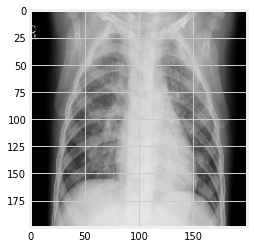

In [ ]:
plt.imshow(train[1][0], cmap = 'gray')
print(labels[train[1][1]])

In [ ]:
X = []
y = []

for feature, label in train:
  X.append(feature)
  y.append(label)

for feature, label in test:
  X.append(feature)
  y.append(label)

for feature, label in val:
  X.append(feature)
  y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train.shape

(4684, 200, 200, 1)

*CNN을 ResNet으로 바꿈*

In [ ]:
Inputs = tf.keras.Input(shape=(200, 200, 1))

x = tf.keras.layers.Conv2D(64, (1,1), strides=1, padding = 'same')(Inputs) #i
x = tf.keras.layers.BatchNormalization(axis = 1)(x)
x = tf.keras.layers.Activation('relu')(x)
block_1_output = tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same')(x)

x= tf.keras.layers.Conv2D(64, (3,3), strides=1, padding = 'same')(block_1_output)     #1st_identity_block
x = tf.keras.layers.BatchNormalization(axis = 1)(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(64, (3,3), strides=1, padding = 'same')(x)
x = tf.keras.layers.BatchNormalization(axis = 1)(x)
block_2_output = tf.keras.layers.add([x, block_1_output])
block_2_a_output = tf.keras.layers.Activation('relu')(block_2_output)

x = tf.keras.layers.Conv2D(32, (1,1), strides=1, padding = 'same')(block_2_a_output)  #2nd_bottleneck_block
x = tf.keras.layers.BatchNormalization(axis = 1)(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(32, (3,3), strides=1, padding = 'same')(x)
x = tf.keras.layers.BatchNormalization(axis = 1)(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(64, (1,1), strides=1, padding = 'same')(x)
x = tf.keras.layers.BatchNormalization(axis = 1)(x)
block_3_output = tf.keras.layers.add([x, block_2_a_output])
x = tf.keras.layers.Activation('relu')(block_3_output)

x = tf.keras.layers.AveragePooling2D(pool_size = (4,4), padding = 'same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(Inputs, outputs, name='ResNet')

In [ ]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 64  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 200, 64  800        ['conv2d[0][0]']                 
 alization)                     )                                                            

In [ ]:
adam = Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 15, epochs = 20, validation_split = 0.20, callbacks = [early_stop])

Epoch 1/20
250/250 [==============================] - 29s 80ms/step - loss: 0.6942 - accuracy: 0.8377 - val_loss: 0.4064 - val_accuracy: 0.9221
Epoch 2/20
250/250 [==============================] - 19s 74ms/step - loss: 0.2653 - accuracy: 0.9247 - val_loss: 0.5485 - val_accuracy: 0.8410
Epoch 3/20
250/250 [==============================] - 20s 79ms/step - loss: 0.2211 - accuracy: 0.9295 - val_loss: 0.2151 - val_accuracy: 0.9306
Epoch 4/20
250/250 [==============================] - 19s 75ms/step - loss: 0.1900 - accuracy: 0.9378 - val_loss: 0.2362 - val_accuracy: 0.9232
Epoch 5/20
250/250 [==============================] - 19s 75ms/step - loss: 0.1543 - accuracy: 0.9442 - val_loss: 0.1564 - val_accuracy: 0.9413
Epoch 6/20
250/250 [==============================] - 19s 76ms/step - loss: 0.1506 - accuracy: 0.9504 - val_loss: 0.1854 - val_accuracy: 0.9338
Epoch 7/20
250/250 [==============================] - 19s 75ms/step - loss: 0.1378 - accuracy: 0.9509 - val_loss: 0.1919 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 3s 60ms/step - loss: 0.2621 - accuracy: 0.9147


[0.26212456822395325, 0.914675772190094]

train과 test를 같이 보는 model accuraccy *그래프*

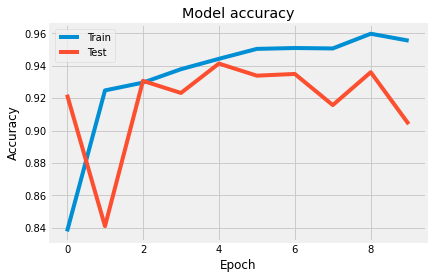

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

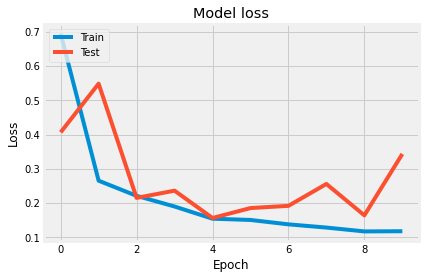

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

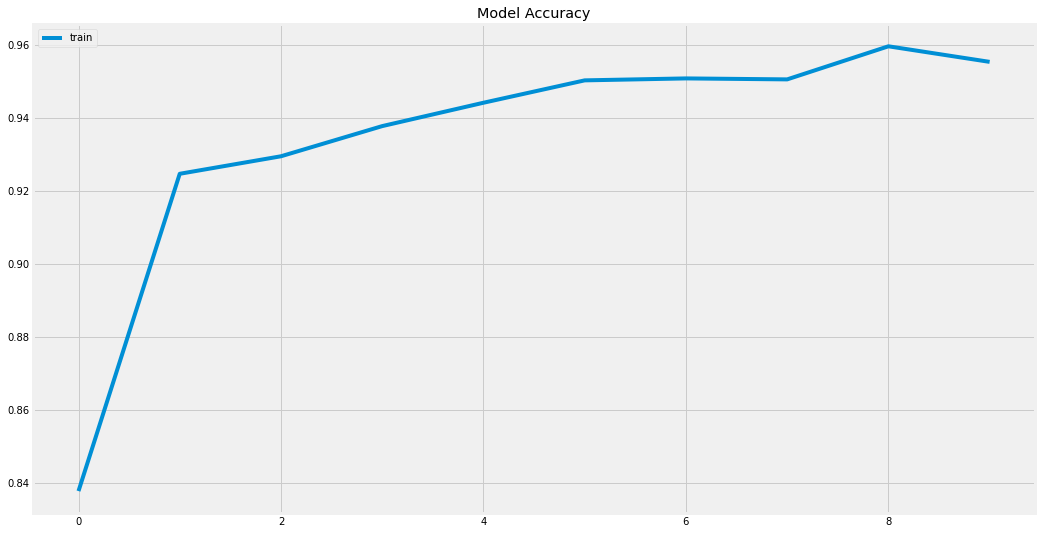

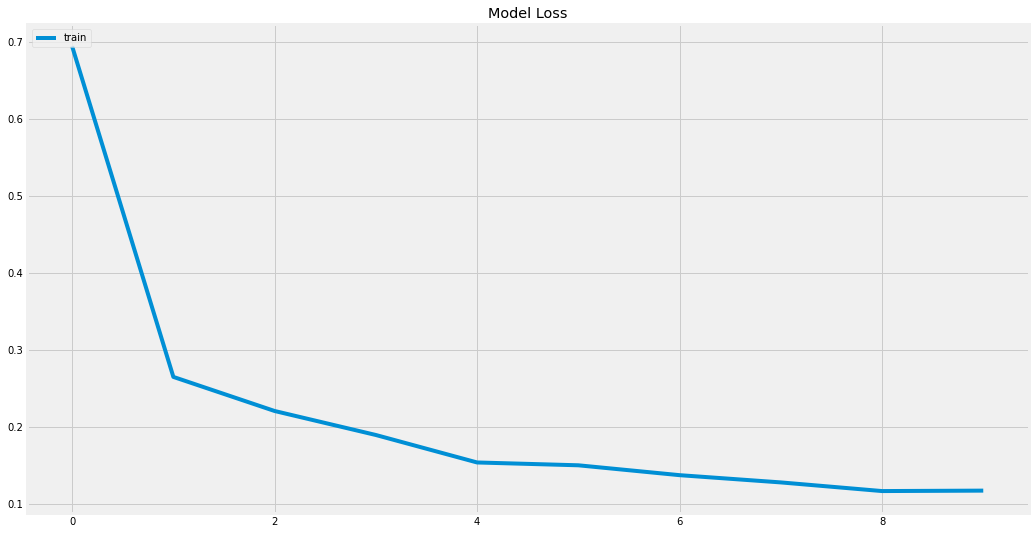

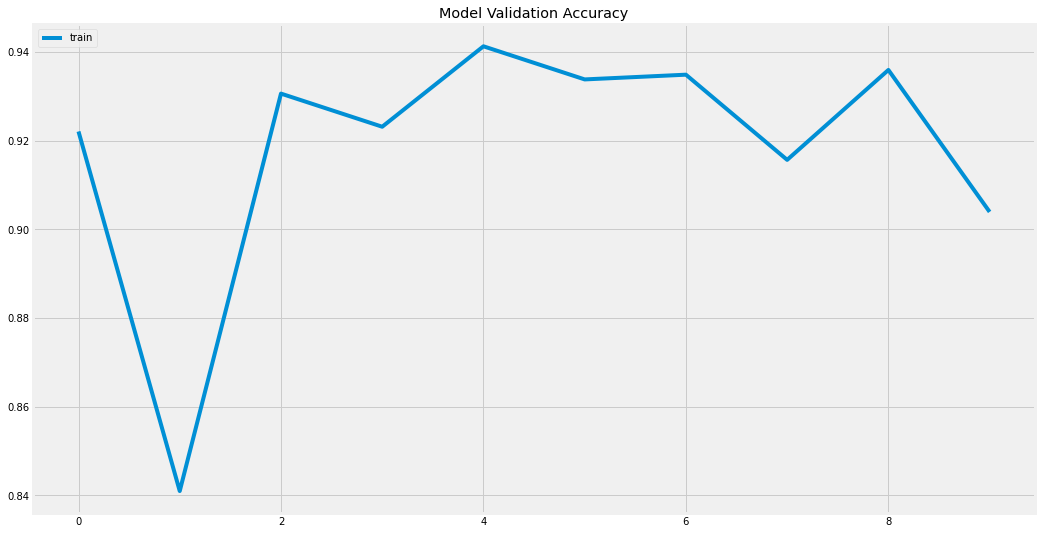

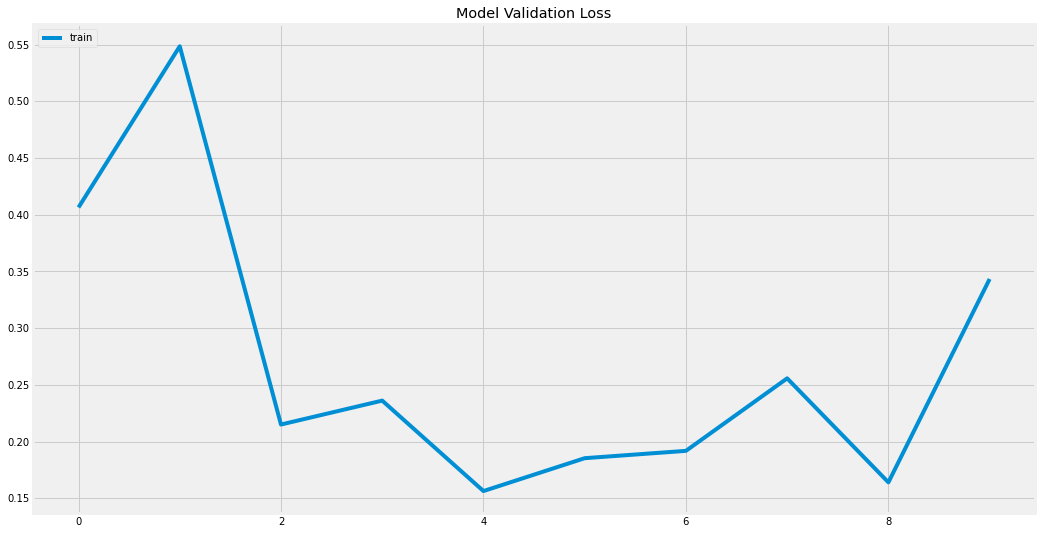

In [ ]:
plt.figure(figsize = (16, 9))
plt.plot(history.epoch, history.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc = 'upper left')
plt.show()

plt.figure(figsize = (16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc = 'upper left')
plt.show()

plt.figure(figsize = (16, 9))
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc = 'upper left')
plt.show()

plt.figure(figsize = (16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

147/147 [==============================] - 7s 49ms/step


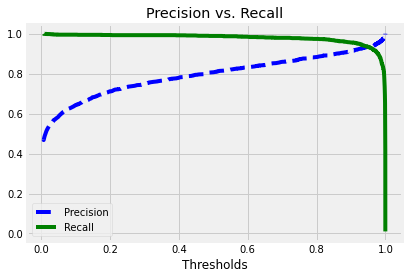

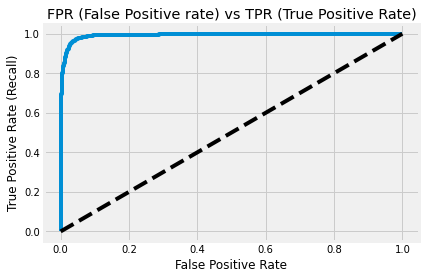

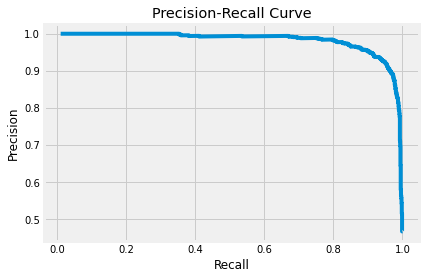

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--')
  plt.plot(thresholds, recalls[:-1], 'g-')
  plt.title('Precision vs. Recall')
  plt.xlabel('Thresholds')
  plt.legend(['Precision', 'Recall'], loc = 'best')
  plt.show()

def plot_precision_recall2(precisions, recalls):
  plt.plot(recalls[:-1], precisions[:-1])
  plt.title('Precision-Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.show()

def plot_roc(fpr, tpr):
  plt.plot(fpr, tpr)
  plt.plot([0 ,1], [0, 1], 'k--')
  plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate (Recall)')
  plt.show()

plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)
plot_precision_recall2(precisions, recalls)

In [ ]:
predictions = model.predict(X_test)

37/37 [==============================] - 2s 50ms/step


In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.95)]
for i in predictions:
  if i >= threshold:
    binary_predictions.append(1)
  else:
    binary_predictions.append(0)

In [ ]:

print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9496587030716723
Precision on testing set: 0.8770226537216829
Recall on testing set: 0.928082191780822


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

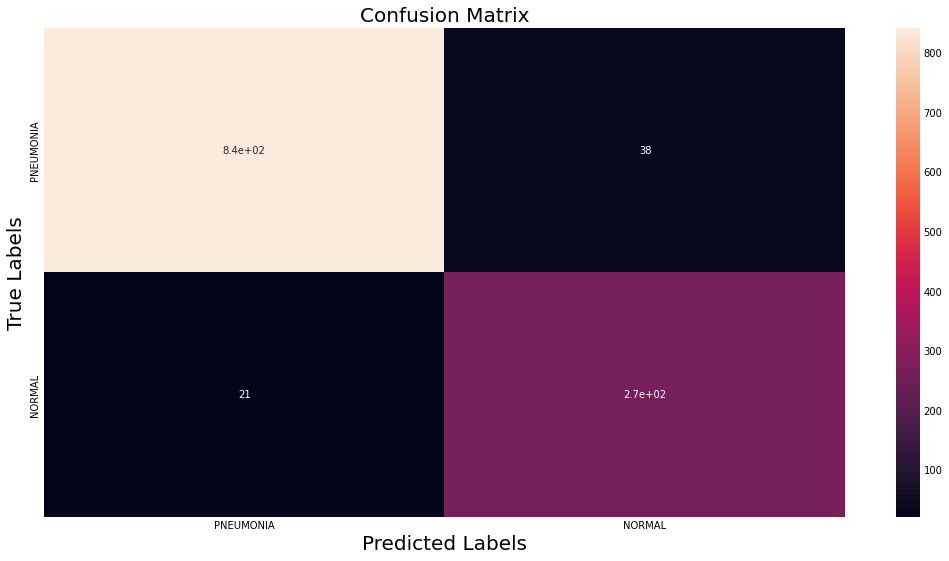

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize = (16, 9))
ax = plt.subplot()
sns.heatmap(matrix, annot = True, ax = ax)

ax.set_xlabel('Predicted Labels', size = 20)
ax.set_ylabel('True Labels', size = 20)
ax.set_title('Confusion Matrix', size = 20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

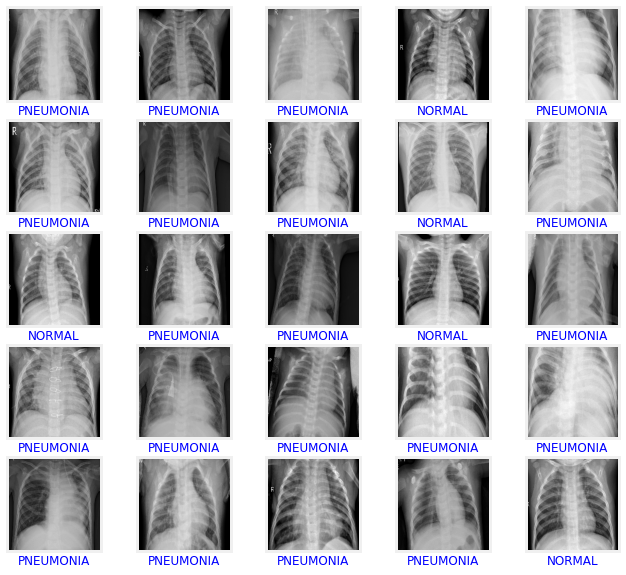

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_test.reshape(-1, img_size, img_size)[i], cmap = 'gray')
  if (binary_predictions[i] == y_test[i]):
    plt.xlabel(labels[binary_predictions[i]], color = 'blue')
  else:
    plt.xlabel(labels[binary_predictions[i]], color = 'red')
plt.show()